In [721]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder,RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras

In [663]:
train                 = pd.read_csv('Data/train.csv')
test                  = pd.read_csv('Data/test.csv')
monthly_expenditures  = pd.read_csv('Data/monthly_expenditures.csv')
sample_submission     = pd.read_csv('Data/sample_submission.csv')

In [664]:
le_egitim                       = LabelEncoder().fit(train['egitim'])
train['egitim']                 = le_egitim.transform(train['egitim'])
test['egitim']                  = le_egitim.transform(test['egitim'])


le_is_durumu                    = LabelEncoder().fit(train['is_durumu'])
train['is_durumu']              = le_is_durumu.transform(train['is_durumu'])
test['is_durumu']               = le_is_durumu.transform(test['is_durumu'])

le_meslek_grubu                 = LabelEncoder().fit(train['meslek_grubu'])
train['meslek_grubu']           = le_meslek_grubu.transform(train['meslek_grubu'])
test['meslek_grubu']            = le_meslek_grubu.transform(test['meslek_grubu'])

le_musteri                      = LabelEncoder().fit(monthly_expenditures['musteri'])
train['musteri']                = le_musteri.transform(train['musteri'])
test['musteri']                 = le_musteri.transform(test['musteri'])
monthly_expenditures['musteri'] = le_musteri.transform(monthly_expenditures['musteri'])

In [665]:
toplam_islem_adedi = monthly_expenditures.groupby('musteri',as_index=False)[['islem_adedi']].sum().rename(columns={'islem_adedi':'toplam_islem_adedi'})

toplam_islem_tutari = monthly_expenditures.groupby('musteri',as_index=False)[['aylik_toplam_tutar']].sum().rename(columns={'aylik_toplam_tutar':'toplam_islem_tutari'})

aylik_ortalama_islem_adedi = monthly_expenditures.groupby(['musteri','tarih'],as_index=False)[['islem_adedi']].sum().groupby('musteri',as_index=False)[['islem_adedi']].mean().rename(columns={'islem_adedi':'aylik_ortalama_islem_adedi'})

aylik_ortalama_islem_tutari = monthly_expenditures.groupby(['musteri','tarih'],as_index=False)[['aylik_toplam_tutar']].sum().groupby('musteri',as_index=False)[['aylik_toplam_tutar']].mean().rename(columns={'aylik_toplam_tutar':'aylik_ortalama_islem_tutari'})


musteri_bilgileri = pd.merge(pd.merge(toplam_islem_adedi,toplam_islem_tutari,on='musteri'),pd.merge(aylik_ortalama_islem_adedi,aylik_ortalama_islem_tutari,on='musteri'))

In [666]:
x_train = pd.merge(train,musteri_bilgileri,on='musteri').drop(columns=['target','musteri','tarih'])
y_train = pd.merge(train,musteri_bilgileri,on='musteri')[['target']]

x_test  = pd.merge(test,musteri_bilgileri,on='musteri').drop(columns=['tarih','musteri'])

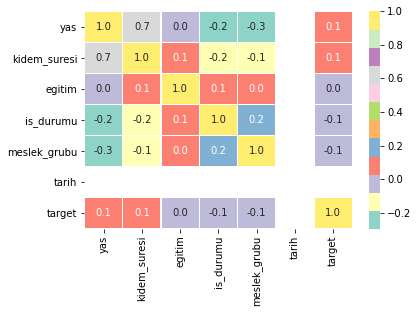

In [667]:
corr = train.drop(columns=['musteri']).corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Set3",fmt='.1f',annot=True);

# Submission 1

In [326]:
sample_submission['target'] = 0
sample_submission.to_csv('Submission/Submission_1.csv',index=False)

## Standard Scaling

In [668]:
standard_scaler  = StandardScaler().fit(x_train)

scaled_x_train   = standard_scaler.transform(x_train)
scaled_x_test    = standard_scaler.transform(x_test)

## Robust Scaling

In [328]:
robust_scaler  = RobustScaler().fit(x_train)

scaled_x_train = robust_scaler.transform(x_train)
scaled_x_test = robust_scaler.transform(x_test)

## MinMax Scaling

In [328]:
minmax_scaler  = MinMaxScaler().fit(x_train)

scaled_x_train = minmax_scaler.transform(x_train)
scaled_x_test = minmax_scaler.transform(x_test)

## Over Sampling

In [669]:
smote_over_sampling = SMOTE(random_state=1)
x_train_resampled, y_train_resampled = smote_over_sampling.fit_sample(scaled_x_train, y_train)

# Submission 2

In [304]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_resampled, y_train_resampled)

/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:15:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [306]:
f1_score(y_train_resampled, xgb_classifier.predict(x_train_resampled))

0.9683592981452003

In [307]:
sample_submission['target'] = xgb_classifier.predict(scaled_x_test)

In [309]:
sample_submission.to_csv('Submission/Submission_2.csv',index=False)

# Submission 3

In [316]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train_resampled, y_train_resampled)

<ipython-input-316-aee262032cd6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(x_train_resampled, y_train_resampled)


RandomForestClassifier()

In [317]:
f1_score(y_train_resampled, rf_classifier.predict(x_train_resampled))

0.999982626522351

In [318]:
sample_submission['target'] = rf_classifier.predict(scaled_x_test)

In [319]:
sample_submission.to_csv('Submission/Submission_3.csv',index=False)

# Submission 4

In [338]:
class_weights = class_weight.compute_class_weight("balanced",np.unique(y_train['target']), y_train['target'])

In [340]:
class_weights

array([ 0.52119527, 12.29508197])

In [342]:
rf_classifier = RandomForestClassifier(class_weight={1:12.29508197, 0:0.52119527})

rf_classifier.fit(scaled_x_train, y_train)

<ipython-input-342-d30d36755bc2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(scaled_x_train, y_train)


RandomForestClassifier(class_weight={0: 0.52119527, 1: 12.29508197})

In [343]:
f1_score(y_train, rf_classifier.predict(scaled_x_train))

0.9995903318312167

In [344]:
sample_submission['target'] = rf_classifier.predict(scaled_x_test)

In [345]:
sample_submission.to_csv('Submission/Submission_4.csv',index=False)

# Submission 5

In [602]:
model = keras.Sequential([
keras.layers.Dense(30, activation=tf.nn.relu,input_shape=(scaled_x_train.shape[1],)),
keras.layers.Dense(60, activation=tf.nn.relu),
keras.layers.Dense(90, activation=tf.nn.relu),
keras.layers.Dense(60, activation=tf.nn.relu),
keras.layers.Dense(30, activation=tf.nn.relu),
keras.layers.Dense(2, activation=tf.nn.softmax)])

model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [603]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                300       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_8 (Dense)              (None, 90)                5490      
_________________________________________________________________
dense_9 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 62        
Total params: 15,002
Trainable params: 15,002
Non-trainable params: 0
__________________________________________________

In [604]:
history = model.fit(scaled_x_train, y_train['target'].values, epochs=100,
                    validation_split=0.2, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47168/48000 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.9586

/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 2s 35us/sample - loss: 0.1634 - accuracy: 0.9588 - val_loss: 0.1596 - val_accuracy: 0.9596
Epoch 2/100
48000/48000 [==============================] - 2s 34us/sample - loss: 0.1570 - accuracy: 0.9593 - val_loss: 0.1549 - val_accuracy: 0.9596
Epoch 3/100
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1566 - accuracy: 0.9593 - val_loss: 0.1544 - val_accuracy: 0.9596
Epoch 4/100
48000/48000 [==============================] - 2s 31us/sample - loss: 0.1563 - accuracy: 0.9593 - val_loss: 0.1547 - val_accuracy: 0.9596
Epoch 5/100
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1556 - accuracy: 0.9593 - val_loss: 0.1561 - val_accuracy: 0.9596
Epoch 6/100
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1554 - accuracy: 0.9593 - val_loss: 0.1549 - val_accuracy: 0.9596
Epoch 7/100
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1551 - accuracy: 0.9593 - va

In [634]:
train_predictions = model.predict(scaled_x_train)
test_predictions = model.predict(scaled_x_test)

In [630]:
sample_submission['target'] = pd.DataFrame(np.around(test_predictions))[1].values

In [633]:
sample_submission.to_csv('Submission/Submission_5.csv',index=False)

# Submission 6

In [677]:
model = keras.Sequential([
keras.layers.Dense(30, activation=tf.nn.relu,input_shape=(x_train_resampled.shape[1],)),
keras.layers.Dense(60, activation=tf.nn.relu),
keras.layers.Dense(90, activation=tf.nn.relu),
keras.layers.Dense(60, activation=tf.nn.relu),
keras.layers.Dense(30, activation=tf.nn.relu),
keras.layers.Dense(2, activation=tf.nn.softmax)])

model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [678]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 30)                300       
_________________________________________________________________
dense_19 (Dense)             (None, 60)                1860      
_________________________________________________________________
dense_20 (Dense)             (None, 90)                5490      
_________________________________________________________________
dense_21 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_22 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 62        
Total params: 15,002
Trainable params: 15,002
Non-trainable params: 0
__________________________________________________

In [679]:
history = model.fit(shuffle(pd.DataFrame(x_train_resampled),random_state=1), shuffle(pd.DataFrame(y_train_resampled),random_state=1), epochs=100,
                    validation_split=0.2, verbose=1)

Train on 92096 samples, validate on 23024 samples
Epoch 1/100
91648/92096 [============================>.] - ETA: 0s - loss: 0.5618 - accuracy: 0.7032

/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


92096/92096 [==============================] - 4s 40us/sample - loss: 0.5618 - accuracy: 0.7033 - val_loss: 0.5419 - val_accuracy: 0.7187
Epoch 2/100
92096/92096 [==============================] - 3s 33us/sample - loss: 0.5360 - accuracy: 0.7212 - val_loss: 0.5317 - val_accuracy: 0.7272
Epoch 3/100
92096/92096 [==============================] - 3s 33us/sample - loss: 0.5173 - accuracy: 0.7345 - val_loss: 0.5056 - val_accuracy: 0.7432
Epoch 4/100
92096/92096 [==============================] - 4s 38us/sample - loss: 0.4980 - accuracy: 0.7457 - val_loss: 0.4891 - val_accuracy: 0.7522
Epoch 5/100
92096/92096 [==============================] - 3s 32us/sample - loss: 0.4834 - accuracy: 0.7553 - val_loss: 0.4842 - val_accuracy: 0.7532
Epoch 6/100
92096/92096 [==============================] - 4s 40us/sample - loss: 0.4674 - accuracy: 0.7664 - val_loss: 0.4631 - val_accuracy: 0.7718
Epoch 7/100
92096/92096 [==============================] - 3s 38us/sample - loss: 0.4522 - accuracy: 0.7773 - va

In [686]:
train_predictions = model.predict(x_train_resampled)
test_predictions = model.predict(scaled_x_test)

/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [694]:
sample_submission['target'] = pd.DataFrame(np.around(test_predictions))[1].values

In [695]:
sample_submission.to_csv('Submission/Submission_6.csv',index=False)

# Submission 7

In [746]:
model = keras.Sequential([
keras.layers.Dense(30, activation=tf.nn.relu,input_shape=(x_train_resampled.shape[1],)),
keras.layers.Dense(30, activation=tf.nn.relu),
keras.layers.Dense(2, activation=tf.nn.softmax)])

model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [747]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 30)                300       
_________________________________________________________________
dense_31 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 62        
Total params: 1,292
Trainable params: 1,292
Non-trainable params: 0
_________________________________________________________________


In [748]:
history = model.fit(shuffle(pd.DataFrame(x_train_resampled),random_state=1), shuffle(pd.DataFrame(y_train_resampled),random_state=1), epochs=500,
                    validation_split=0.2, verbose=1)

Train on 92096 samples, validate on 23024 samples
Epoch 1/500
90944/92096 [============================>.] - ETA: 0s - loss: 0.5734 - accuracy: 0.6922

/Users/sufyan/Desktop/İşBankası ML Challenge TR 3/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


92096/92096 [==============================] - 2s 27us/sample - loss: 0.5732 - accuracy: 0.6925 - val_loss: 0.5591 - val_accuracy: 0.7070
Epoch 2/500
92096/92096 [==============================] - 2s 24us/sample - loss: 0.5548 - accuracy: 0.7093 - val_loss: 0.5484 - val_accuracy: 0.7138
Epoch 3/500
92096/92096 [==============================] - 2s 24us/sample - loss: 0.5484 - accuracy: 0.7146 - val_loss: 0.5445 - val_accuracy: 0.7179
Epoch 4/500
92096/92096 [==============================] - 2s 25us/sample - loss: 0.5432 - accuracy: 0.7182 - val_loss: 0.5430 - val_accuracy: 0.7191
Epoch 5/500
92096/92096 [==============================] - 2s 24us/sample - loss: 0.5390 - accuracy: 0.7205 - val_loss: 0.5351 - val_accuracy: 0.7204
Epoch 6/500
92096/92096 [==============================] - 2s 25us/sample - loss: 0.5350 - accuracy: 0.7226 - val_loss: 0.5315 - val_accuracy: 0.7256
Epoch 7/500
92096/92096 [==============================] - 2s 25us/sample - loss: 0.5315 - accuracy: 0.7261 - va

In [749]:
train_predictions = model.predict(x_train_resampled)
test_predictions = model.predict(scaled_x_test)

In [750]:
sample_submission['target'] = pd.DataFrame(np.around(test_predictions))[1].values

In [751]:
sample_submission.to_csv('Submission/Submission_7.csv',index=False)